<a href="https://colab.research.google.com/github/sreshu/ADA-Questions-Hacktober-Fest/blob/master/MovieLensAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing all the neccesary libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile

import warnings
warnings.filterwarnings('ignore')

In [2]:
#importing the movie lens dataset directly to colab
!wget --no-check-certificate https://files.grouplens.org/datasets/movielens/ml-25m.zip


--2023-08-09 21:09:47--  https://files.grouplens.org/datasets/movielens/ml-25m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 261978986 (250M) [application/zip]
Saving to: ‘ml-25m.zip’

ml-25m.zip          100%[===================>] 249.84M  49.9MB/s    in 5.4s    

2023-08-09 21:09:53 (46.6 MB/s) - ‘ml-25m.zip’ saved [261978986/261978986]



In [3]:
#unzipping the data to read the csv's
local_zip = './ml-25m.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()

In [4]:
%%time

#consisit of 25M ratings
rating_df = pd.read_csv('/ml-25m/ratings.csv')

#consist of tags/comments from user
tags_df = pd.read_csv('/ml-25m/tags.csv')

#consist of movie titles
title_df = pd.read_csv('/ml-25m/movies.csv')

CPU times: user 8.96 s, sys: 1.41 s, total: 10.4 s
Wall time: 12.1 s


In [5]:
#looking for some initial statistics of data
print('No of Users who rated movies:', rating_df.userId.nunique())
print('No of Movies:', rating_df.movieId.nunique())
print('No of ratings:', rating_df.rating.count())
print('No of user comments:', tags_df.tag.nunique())
print('No of Movies commented by user:', tags_df.movieId.nunique())
print('Percentage of user commented:', (tags_df.tag.nunique()/rating_df.userId.nunique())*100, '%')
print('No of movies commented by user:', (tags_df.movieId.nunique()/rating_df.movieId.nunique())*100, '%')

No of Users who rated movies: 162541
No of Movies: 59047
No of ratings: 25000095
No of user comments: 73050
No of Movies commented by user: 45251
Percentage of user commented: 44.942506813665474 %
No of movies commented by user: 76.63556150185445 %


In [6]:


df1 = rating_df.copy()
df2 = tags_df.copy()
df3 = title_df.copy()
del df1['timestamp']
del df2['timestamp']



In [7]:
# seperate year from title
#seperate genre in each colum

#add year from title feature
ss = df3['title'].str.findall('\((\d{4})\)').str.get(0)
df3['Year'] = ss

#seperate genre for each movie and count genres
sss = df3['genres'].str.split(pat='|', expand=True).fillna(0)
sss.columns = ['genre1', 'genre2', 'genre3', 'genre4', 'genre5', 'genre6', 'genre7', 'genre8', 'genre9', 'genre10']
cols = sss.columns
sss[cols] = sss[cols].astype('category')
ss1 = sss.copy()
cat_columns = ss1.select_dtypes(['category']).columns

#count genres (non zeros)
ss1[cat_columns] = ss1[cat_columns].apply(lambda x: x.cat.codes)
ss1['genre_count'] = ss1[cols].gt(0).sum(axis=1) #count greater than 0 values for less than: df[cols].lt(0).sum(axis=1), for equal==0: df[cols].eq(0).sum(axis=1)

#assigning everything to same dataframe
df3['genre_count'] = ss1['genre_count']
df3[cols] = sss[cols]

df3.head()

,movieId,title,genres,Year,genre_count,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3,Adventure,Children,Fantasy,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,2,Comedy,Romance,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,3,Comedy,Drama,Romance,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,1,Comedy,0,0,0,0,0,0,0,0,0


In [8]:
#avg movie ratings by movied id and count
#avg movie ratings by user id and count
rating_avg = df1.groupby('movieId')['rating'].mean().reset_index()
rating_avg = pd.DataFrame(rating_avg)

rating_count = df1.groupby('movieId')['rating'].count().reset_index()
rating_count = pd.DataFrame(rating_count)
rating_count.rename({'rating': 'rating_count'}, axis=1, inplace=True)

user_rating = df1.groupby('userId')['rating'].mean().reset_index()
user_rating = pd.DataFrame(user_rating)

user_count = df1.groupby('userId')['rating'].count().reset_index()
user_count = pd.DataFrame(user_count)
user_count.rename({'rating': 'rating_count'}, axis=1, inplace=True)

df_movie = rating_avg.merge(rating_count, on = 'movieId', how='inner')

df_user = user_rating.merge(user_count, on = 'userId', how='inner')


In [9]:
df_user.head() #avg rating given by a user and its count


,userId,rating,rating_count
0,1,3.814286,70
1,2,3.630435,184
2,3,3.697409,656
3,4,3.378099,242
4,5,3.752475,101


In [10]:
df_movie.head() #avg rating on a movie and count

,movieId,rating,rating_count
0,1,3.893708,57309
1,2,3.251527,24228
2,3,3.142028,11804
3,4,2.853547,2523
4,5,3.058434,11714


In [11]:
#add genre to tags_df --> for word cloud
cols = ['movieId','genre1']
dfk = df3[cols]
df2 = df2.merge(dfk, on = 'movieId', how='inner')
df2.head(3)


,userId,movieId,tag,genre1
0,3,260,classic,Action
1,3,260,sci-fi,Action
2,110,260,action,Action


In [12]:
#user movie tags (just for checking spaming)
user_tags = df2.groupby(['userId', 'movieId'])['tag'].count().reset_index()
user_tags = pd.DataFrame(user_tags)
user_tags[user_tags['tag']==user_tags.tag.max()]

,userId,movieId,tag
91271,31047,318,337


In [13]:
#user tag count  --> add
user_tagcount = df2.groupby('userId')['tag'].count().reset_index()
user_tagcount = pd.DataFrame(user_tagcount)
user_tagcount.rename({'tag': 'tag_count'}, axis=1, inplace=True)

user_tagcount.head(3)


,userId,tag_count
0,3,2
1,4,13
2,19,8


In [14]:


#movie tag count --> movie year & genres
movie_tagcount = df2.groupby('movieId')['tag'].count().reset_index()
movie_tagcount = pd.DataFrame(movie_tagcount)
movie_tagcount.rename({'tag': 'tag_count'}, axis=1, inplace=True)

movie_tagcount.head(3)



,movieId,tag_count
0,1,697
1,2,180
2,3,29


In [15]:
cols = ['movieId','genre_count', 'genre1']
dfs = df3[cols]
movie_tagcount = movie_tagcount.merge(dfs, on = 'movieId', how='inner')
movie_tagcount.head(3)

,movieId,tag_count,genre_count,genre1
0,1,697,5,Adventure
1,2,180,3,Adventure
2,3,29,2,Comedy


In [16]:
df3 = df3.merge(df_movie, on = 'movieId', how='inner')
df3.rename({'rating': 'avg_rating'}, axis=1, inplace=True)
df3.head(3)

,movieId,title,genres,Year,genre_count,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,avg_rating,rating_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0,3.893708,57309
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3,Adventure,Children,Fantasy,0,0,0,0,0,0,0,3.251527,24228
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,2,Comedy,Romance,0,0,0,0,0,0,0,0,3.142028,11804


In [ ]:
#descriptive statistics
#df3 title, year, genres, genre_count --> avg rating and count can be added
#df_user: avg_rating and count by user
#df_movie: avg_rating and count on movie
#df2: userid, movieid, tags, genre
#user_tags: tags by user on each movie
#user_tagcount: user activity
#movie_tagcount: tags & genre count by movie and genre 1

In [17]:
df3.describe()

,movieId,genre_count,avg_rating,rating_count
count,59047.000000,59047.000000,59047.000000,59047.000000
mean,120692.748065,1.733704,3.071374,423.393144
std,64452.508194,1.066425,0.739840,2477.885821
min,1.000000,0.000000,0.500000,1.000000
25%,78277.000000,1.000000,2.687500,2.000000
50%,136782.000000,2.000000,3.150000,6.000000
75%,173812.000000,2.000000,3.500000,36.000000
max,209171.000000,10.000000,5.000000,81491.000000


In [18]:
df3.describe(include=[object, 'category'])

,title,genres,Year,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10
count,59047,59047,58675,59047,59047,59047,59047,59047,59047,59047,59047,59047,59047
unique,58958,1621,135,20,19,18,17,14,12,9,4,2,2
top,Blackout (2007),Drama,2015,Drama,0,0,0,0,0,0,0,0,0
freq,2,8637,2449,14624,28670,46042,55532,58235,58897,59020,59044,59046,59046


In [19]:
df_user.describe()

,userId,rating,rating_count
count,162541.00000,162541.000000,162541.000000
mean,81271.00000,3.679205,153.807932
std,46921.68939,0.477368,268.047590
min,1.00000,0.500000,20.000000
25%,40636.00000,3.398747,36.000000
50%,81271.00000,3.700000,71.000000
75%,121906.00000,4.000000,162.000000
max,162541.00000,5.000000,32202.000000


In [20]:
df2.describe(include=[object, 'category'])

,tag,genre1
count,1093344,1093360
unique,73050,20
top,sci-fi,Action
freq,8330,274209


In [21]:
user_tags.describe()

,userId,movieId,tag
count,305356.000000,305356.000000,305356.000000
mean,69858.647739,54790.762428,3.580555
std,49187.489583,58898.820535,4.247787
min,3.000000,1.000000,0.000000
25%,21096.000000,3249.750000,1.000000
50%,64333.000000,33794.000000,2.000000
75%,112925.000000,97188.000000,4.000000
max,162534.000000,209063.000000,337.000000


In [22]:
user_tagcount.describe(include='all')

,userId,tag_count
count,14592.000000,14592.000000
mean,81145.096697,74.927632
std,46809.759628,1570.072542
min,3.000000,1.000000
25%,40637.500000,2.000000
50%,81224.500000,5.000000
75%,121871.000000,20.000000
max,162534.000000,183356.000000


In [23]:
movie_tagcount.describe(include='all')

,movieId,tag_count,genre_count,genre1
count,45251.000000,45251.000000,45251.000000,45251
unique,NaN,NaN,NaN,20
top,NaN,NaN,NaN,Drama
freq,NaN,NaN,NaN,11701
mean,106384.672206,24.161764,1.830567,NaN
std,62915.776571,107.208231,1.056042,NaN
min,1.000000,1.000000,0.000000,NaN
25%,55009.500000,2.000000,1.000000,NaN
50%,121797.000000,5.000000,2.000000,NaN
75%,159553.000000,13.000000,2.000000,NaN


In [24]:
df3.head(2)

,movieId,title,genres,Year,genre_count,genre1,genre2,genre3,genre4,genre5,genre6,genre7,genre8,genre9,genre10,avg_rating,rating_count
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,5,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0,3.893708,57309
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,3,Adventure,Children,Fantasy,0,0,0,0,0,0,0,3.251527,24228


<Axes: xlabel='Year', ylabel='Density'>

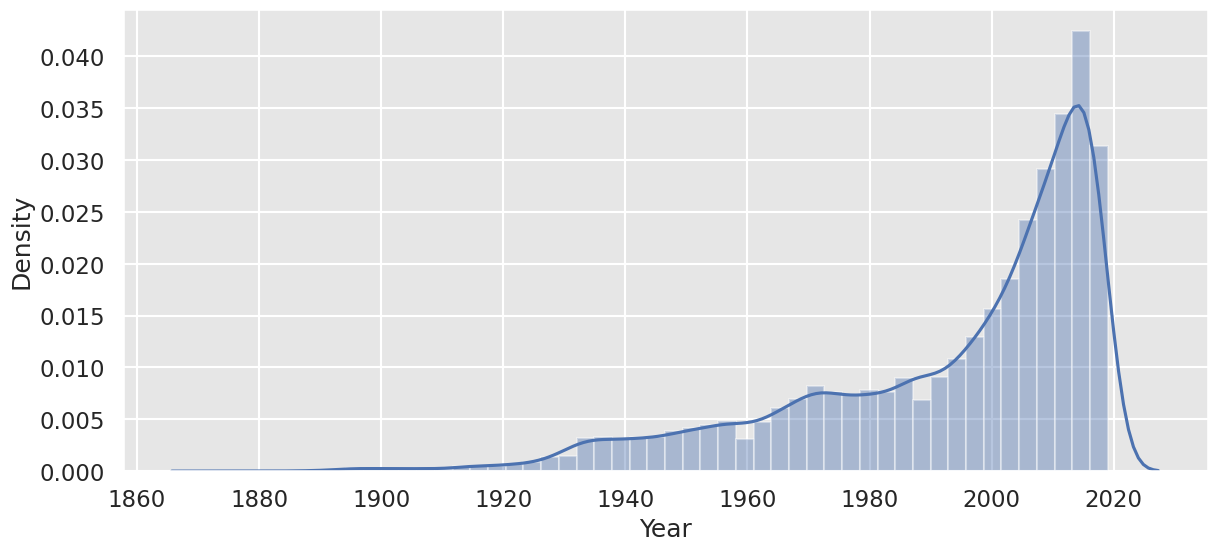

In [25]:
sns.set(rc={'figure.figsize':(14, 6)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"}) #sns.axes_style("whitegrid")

sns.distplot(df3.Year)

(1940.0, 2020.0)

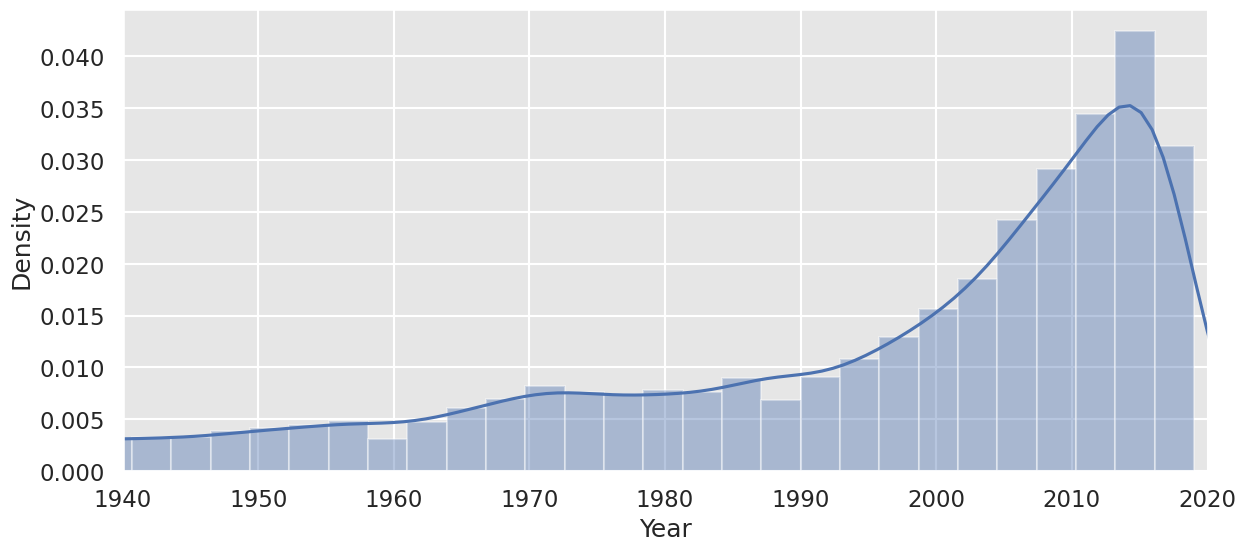

In [26]:
#zooming in:
sns.distplot(df3.Year)
plt.xlim(1940, 2020)

In [27]:
genre = df3.genre1.value_counts()
genre = pd.DataFrame(genre)
genre = genre.reset_index()
genre.rename({'index': 'genre', 'genre1':'Count'}, axis=1, inplace=True)

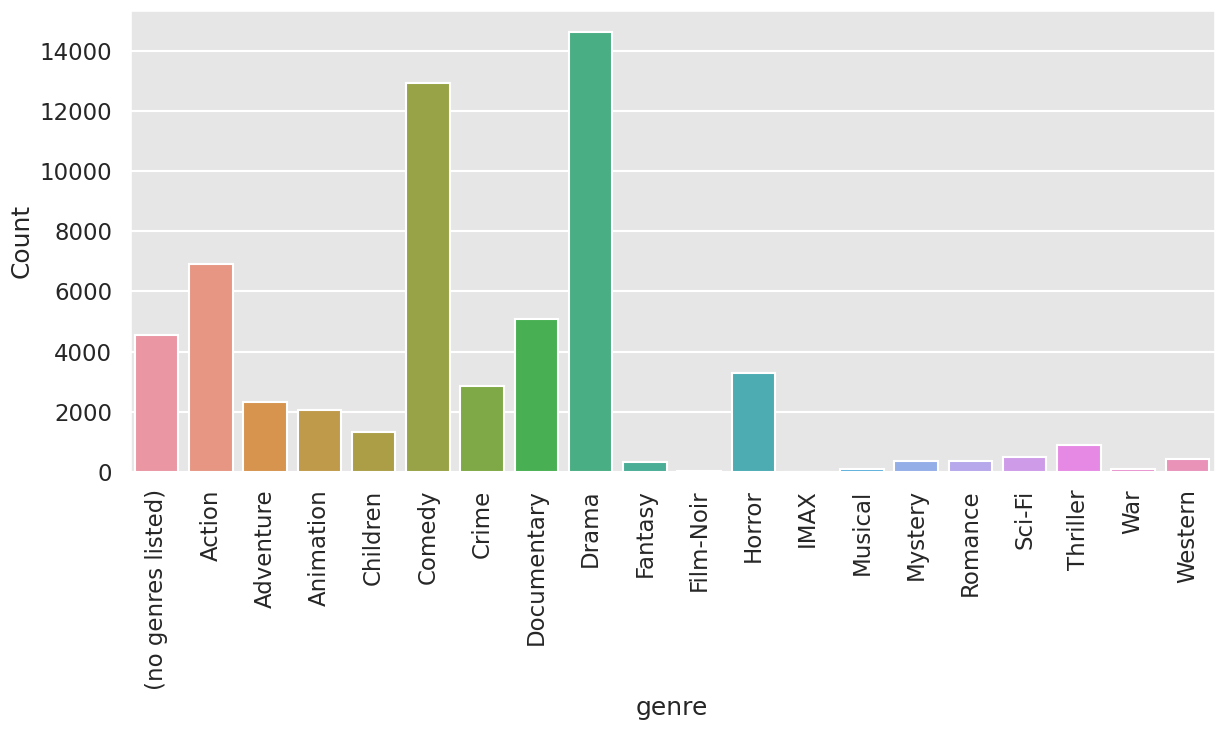

In [28]:
sns.barplot(x = genre.genre, y=genre.Count)
plt.xticks(rotation=90)
plt.show()

In [29]:


genre1 = df3.groupby('genre1')['rating_count'].mean()
genre1 = pd.DataFrame(genre1)
genre1 = genre1.reset_index()
genre1.rename({'rating_count':'avg_count_per_genre'}, axis=1, inplace=True)



Text(0, 0.5, '')

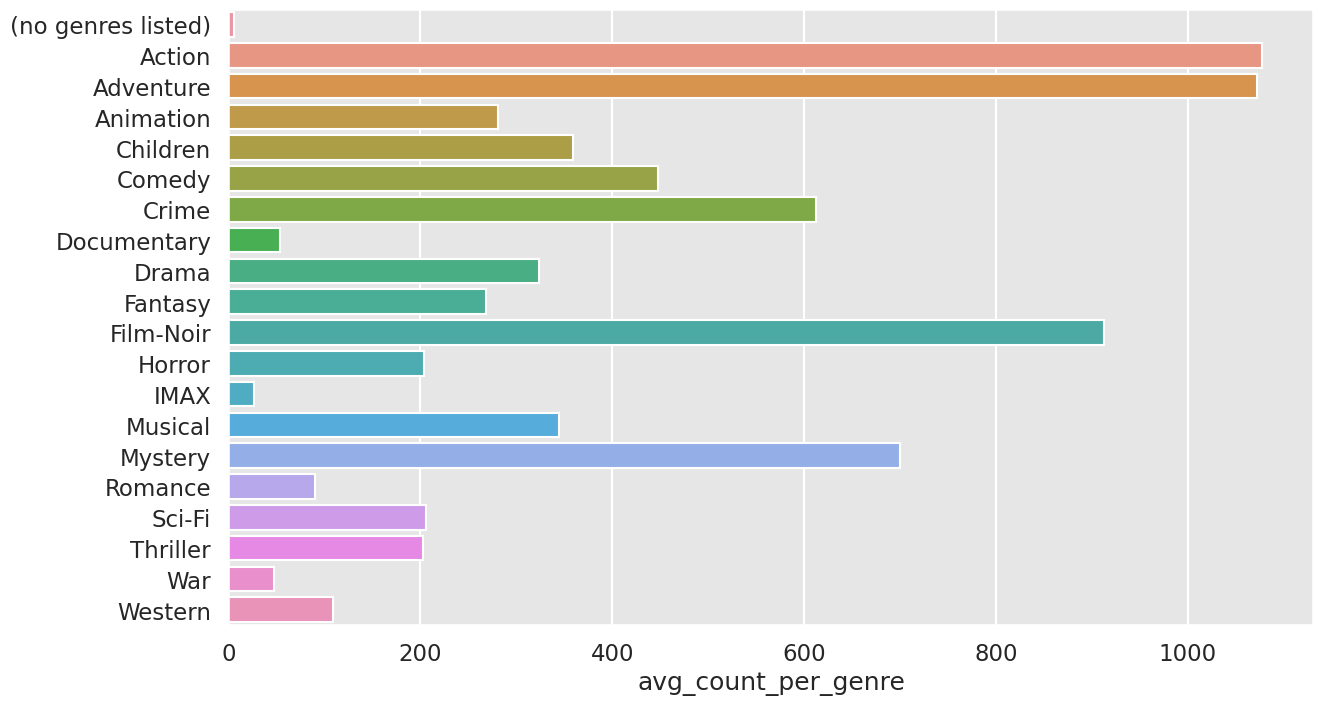

In [30]:
sns.set(rc={'figure.figsize':(14, 8)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.barplot(x = genre1.avg_count_per_genre, y=genre1.genre1)
plt.ylabel("")

In [31]:
cols = ['movieId', 'genre1']
b1 = df3[cols]
box_genre = df1.merge(b1, on='movieId', how='inner')

(-2.0, 7.0)

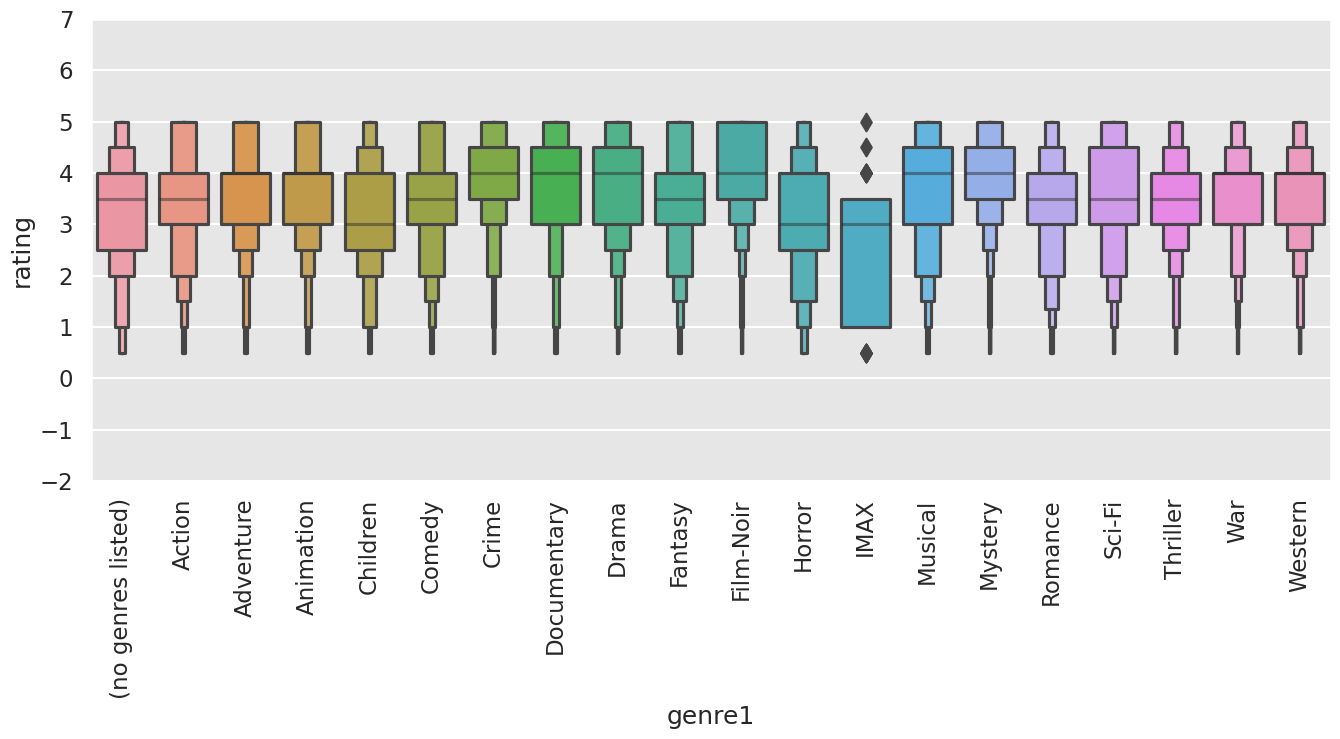

In [32]:
sns.set(rc={'figure.figsize':(16, 6)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.boxenplot(x=box_genre.genre1, y=box_genre.rating, data=box_genre)
plt.xticks(rotation=90)
plt.ylim(-2, 7)

In [33]:
df = df2[df2['genre1']=='Comedy']

In [34]:
from wordcloud import WordCloud

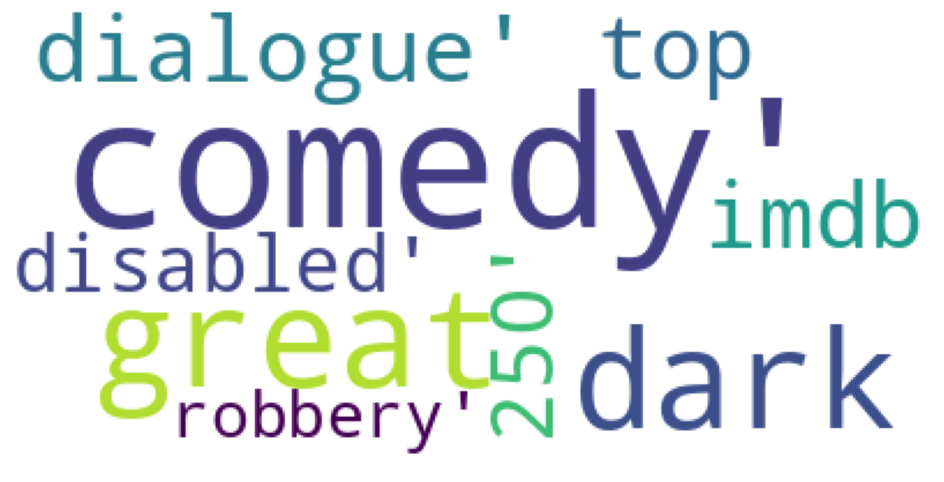

In [35]:
#Drama
text = df['tag'].values

wordcloud = WordCloud(background_color ='white', relative_scaling=0.5).generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

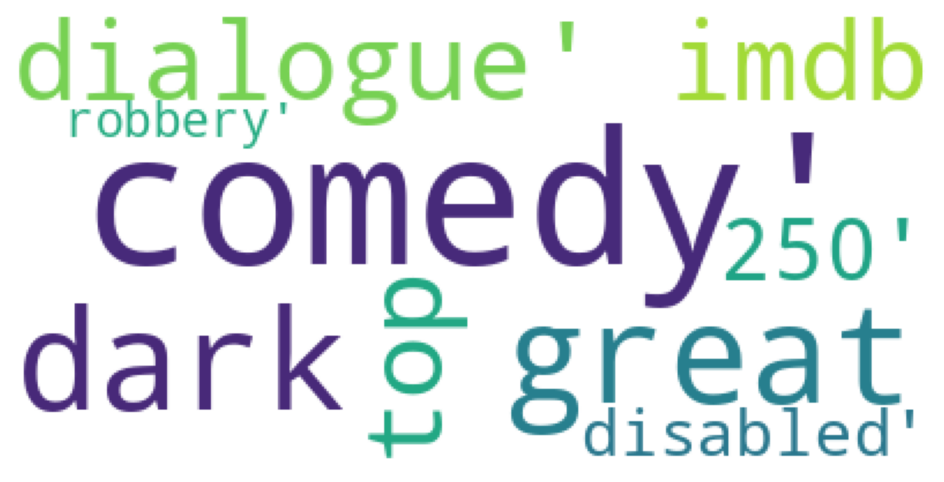

In [36]:
#Action
text = df['tag'].values

wordcloud = WordCloud(background_color ='white').generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

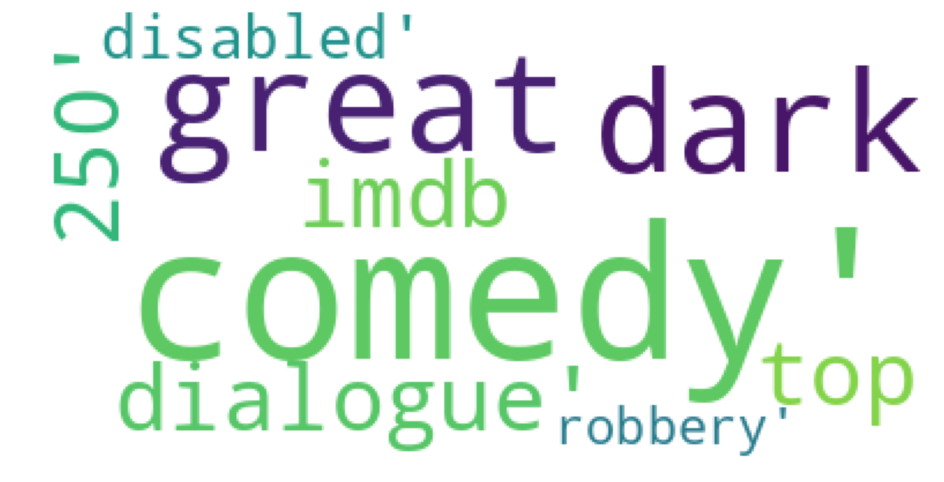

In [37]:
#Comedy
text = df['tag'].values

wordcloud = WordCloud(background_color ='white').generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [38]:
#movie produced each year for each genre (stacked bar)
genre_by_year = df3.groupby(['Year', 'genre1'])['title'].count().reset_index()
genre_by_year  = pd.DataFrame(genre_by_year)
genre_by_year.tail()


,Year,genre1,title
2695,2019,Romance,7
2696,2019,Sci-Fi,13
2697,2019,Thriller,30
2698,2019,War,1
2699,2019,Western,5


In [39]:
genre_by_year.shape

(2700, 3)

In [40]:
#since we already seen that move of the movies were after 1940s - 1950's, so we filter out every thing before it
genre_by_year1 = genre_by_year[genre_by_year['Year']>='1945']
genre_by_year1.shape

(1500, 3)

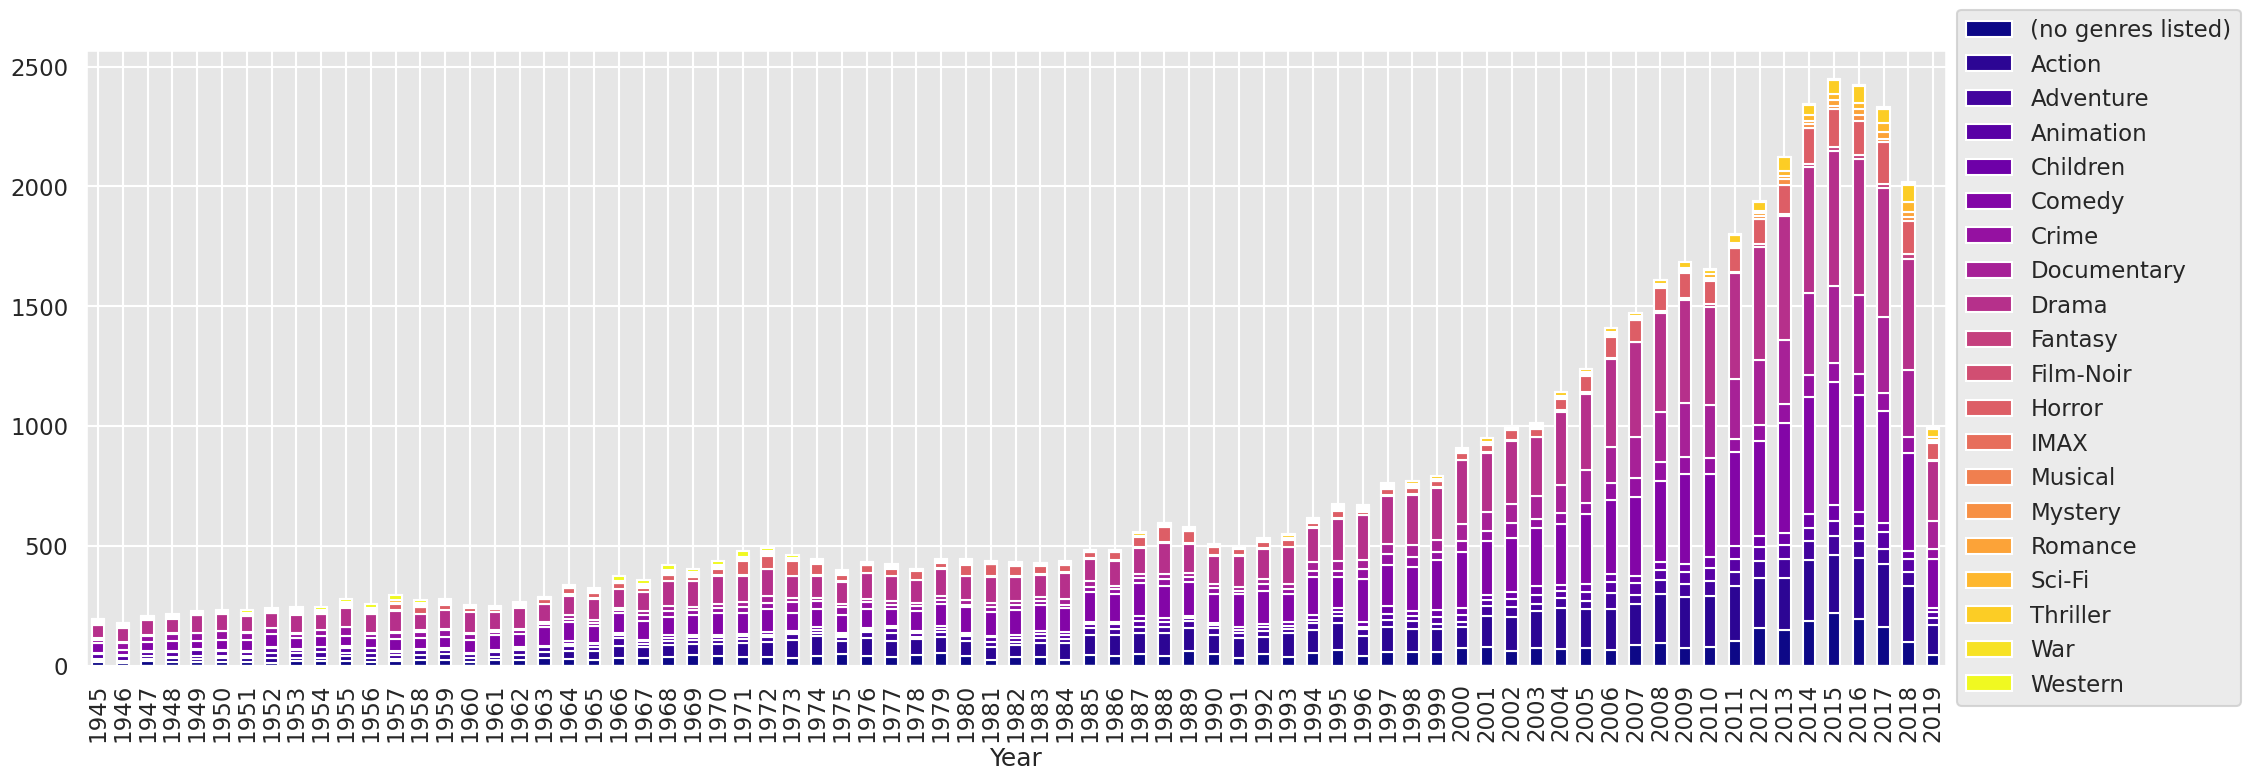

In [41]:
sns.set(rc={'figure.figsize':(24, 8)})
sns.set_context("talk")
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

df_pivot = pd.pivot_table(genre_by_year1, index='Year', columns='genre1', values='title')
df_pivot.plot.bar(stacked=True, colormap='plasma')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [42]:


#genre popularity each year
genre_pop = df3.groupby(['genre1', 'Year' ])['avg_rating'].mean().reset_index()
genre_pop  = pd.DataFrame(genre_pop)
genre_pop.tail()



,genre1,Year,avg_rating
2695,Western,2015,3.866135
2696,Western,2016,2.200000
2697,Western,2017,2.806809
2698,Western,2018,3.018092
2699,Western,2019,2.267031


In [43]:
genre_pop1 = genre_pop.copy()



dfgen2 = genre_pop1[genre_pop1['genre1']=='Comedy']
dfgen3 = genre_pop1[genre_pop1['genre1']=='Documentary']
dfgen4 = genre_pop1[genre_pop1['genre1']=='Horror']
dfgen = genre_pop1[genre_pop1['genre1']=='Action']
dfgen1 = genre_pop1[genre_pop1['genre1']=='Drama']



In [45]:


#top 10 movies with rating count via swarmplot
top10_mov = df3.sort_values(by=['rating_count'], ascending=False)
top10_mov = top10_mov.head(10)
cols = ['movieId', 'title']
top10mov = top10_mov[cols]
top10mov.head()



,movieId,title
351,356,Forrest Gump (1994)
314,318,"Shawshank Redemption, The (1994)"
292,296,Pulp Fiction (1994)
585,593,"Silence of the Lambs, The (1991)"
2480,2571,"Matrix, The (1999)"


In [46]:


top10mov = top10mov.merge(df1, on = 'movieId', how='inner')
top10mov.shape



(700675, 4)

In [47]:
top10mov.head()

,movieId,title,userId,rating
0,356,Forrest Gump (1994),2,4.5
1,356,Forrest Gump (1994),3,4.0
2,356,Forrest Gump (1994),5,4.0
3,356,Forrest Gump (1994),8,5.0
4,356,Forrest Gump (1994),9,5.0


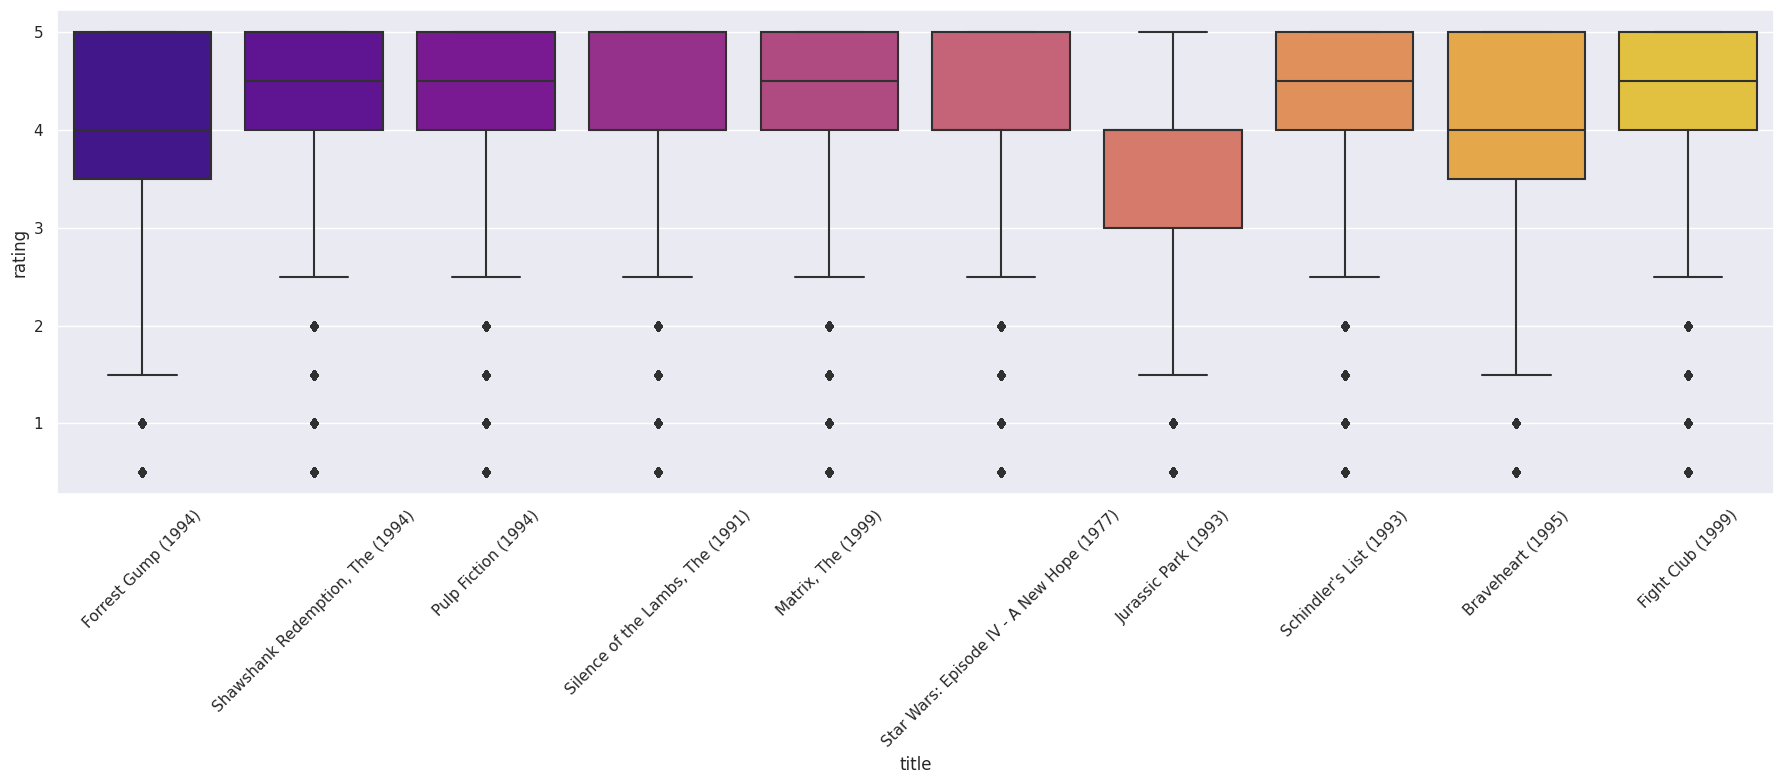

In [48]:
sns.set(rc={'figure.figsize':(18, 8)})
sns.boxplot(x='title', y='rating', data=top10mov, palette ='plasma')
plt.xticks(rotation=45)
plt.tight_layout()

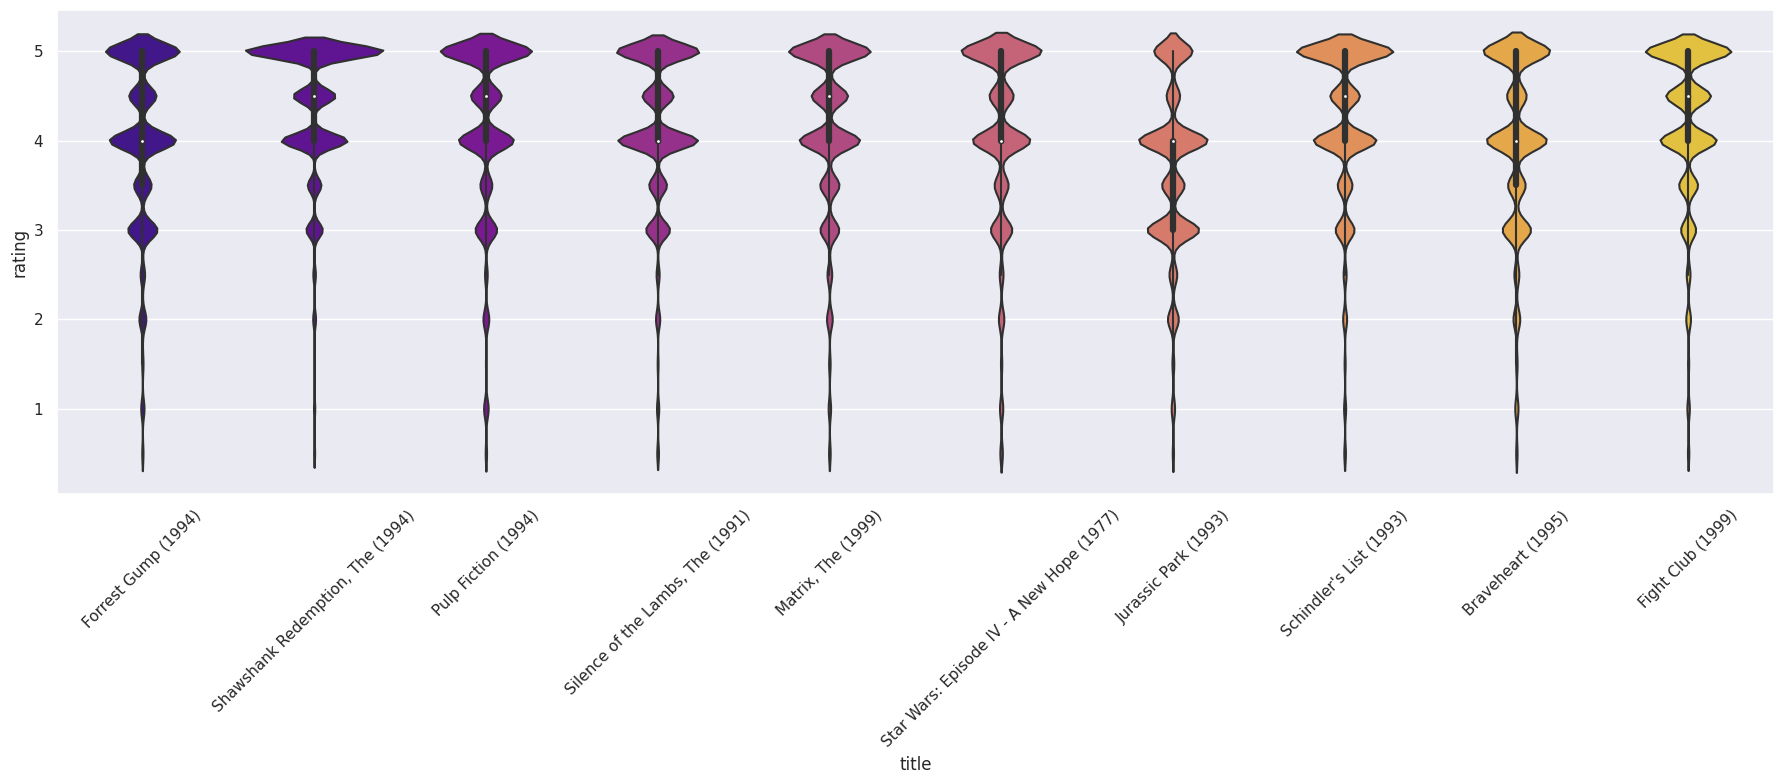

In [49]:
sns.set(rc={'figure.figsize':(18, 8)})
sns.violinplot(x='title', y='rating', data=top10mov, palette ='plasma')
plt.xticks(rotation=45)
plt.tight_layout()


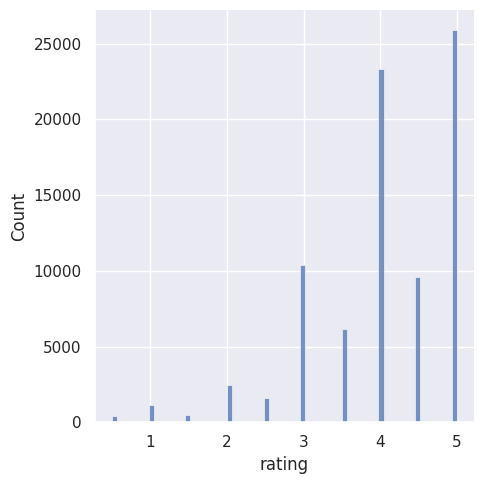

In [50]:


kkk = top10mov[top10mov['movieId']==356]
sns.displot(kkk.rating)



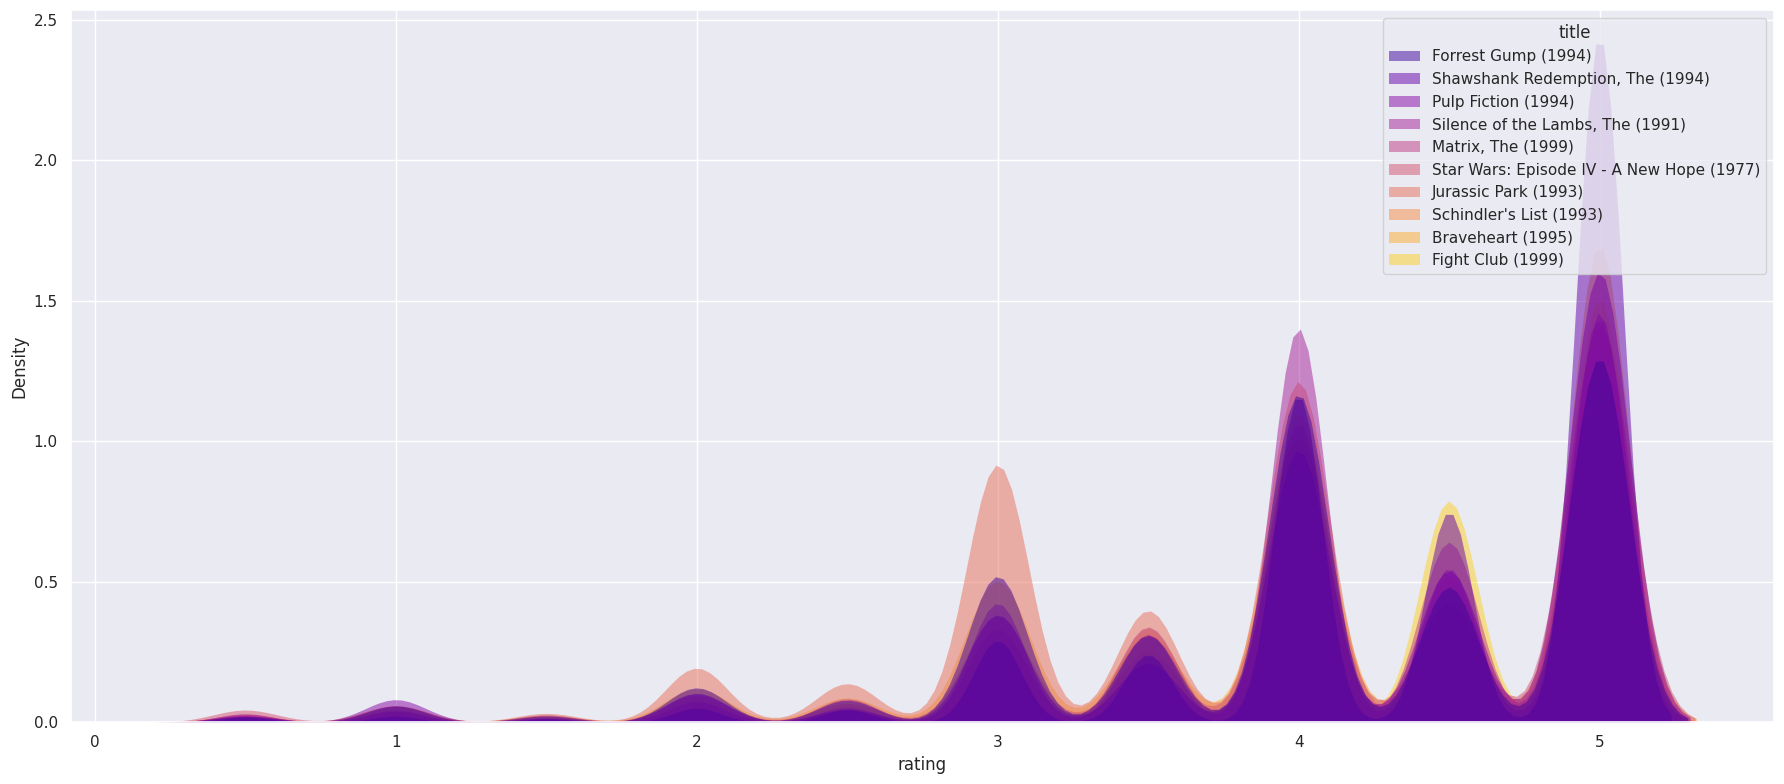

In [51]:
sns.kdeplot(data=top10mov, x='rating', hue='title', fill=True, common_norm=False, palette="plasma", alpha=.5, linewidth=0,)
plt.tight_layout()

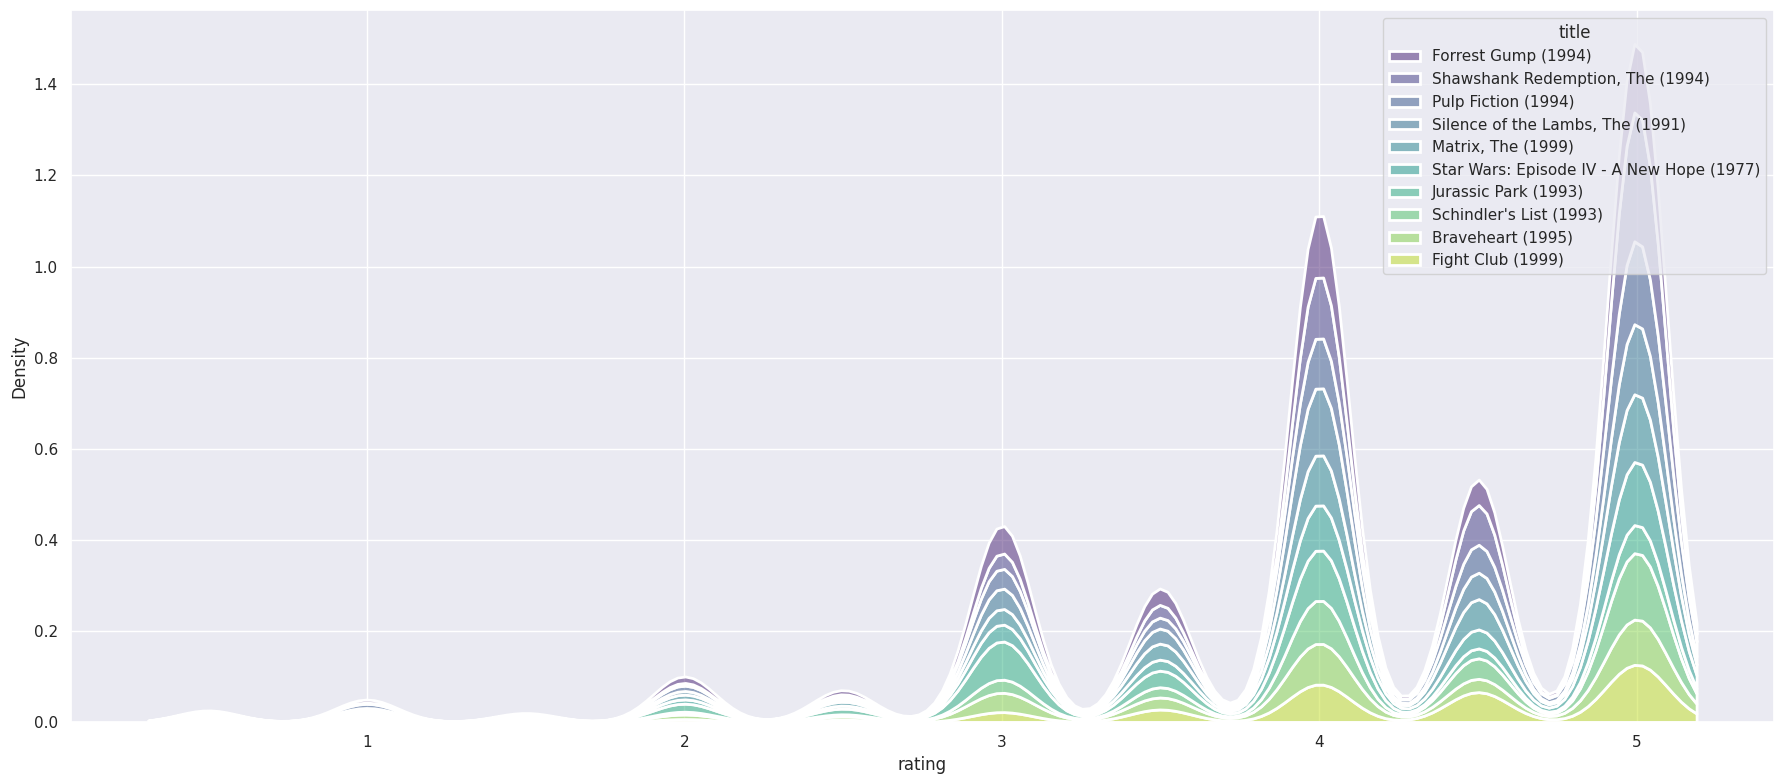

In [52]:
sns.kdeplot(data=top10mov, x='rating', hue='title', alpha=.5, linewidth=2, multiple="stack", palette="viridis")
plt.tight_layout()
